# 人脸验证
1. create 创建一个facelistID,并命名，请求成功后返回空字符串
2. add face 上传一张可供识别的照片，请求成功后返回persistedFaceld
3. detect 准备被检测人脸的id
4. find similars 返回相似置信度

In [1]:
import pandas as pd
import requests
import json

### 1. 创建facelistid存储人脸图像

In [2]:
# 创建 facelistiid
create_face_url = "https://westcentralus.api.cognitive.microsoft.com/face/v1.0/facelists/{faceListId}" 
subscription_key = "245bcfd33b144aacbec8316eee299c1e"
assert subscription_key

headers = {
    'Content-Type': 'application/json',
    'Ocp-Apim-Subscription-Key': subscription_key,
}

data = {
    "name": "beauty_list",
    "userData": "User-provided data attached to the face list.",
    "recognitionModel": "recognition_02"
}
params = {
    # Request parameters    
   
    "faceListId":"test_04"
    
#     'detectionModel': 'detection_01',
}

r_create = requests.put(create_face_url,headers=headers,params=params,json=data)

In [14]:
# 请求成功，返回空字符串
r_create.status_code
# 409代码的意思是这个组别已存在，第一次运行会返回200，多次运行后返回409

409

### 2. 添加人脸图像到facelist，每张图片只能由一张脸

In [4]:
# 增加人脸 往数据库里加人脸（并不是要检测的人脸）
add_face_url = "https://westcentralus.api.cognitive.microsoft.com/face/v1.0/facelists/{faceListId}/persistedFaces"

img =["https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=3018239482,1622546376&fm=11&gp=0.jpg",
     "https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=3522466026,3408873507&fm=26&gp=0.jpg",
     "https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2522261743,1544034345&fm=26&gp=0.jpg"]

# 注意图片里只能有一张脸
#img_url = "https://ss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=2165871283,2672833865&fm=26&gp=0.jpg"
 #   "https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=1246839106,4027627854&fm=11&gp=0.jpg"

params_add_face={
    "faceListId":"test_04"
}
#r_add_face = requests.post(add_face_url,headers=headers,params=params_add_face,json={"url":img_url})
for i in img:
    r_add_face = requests.post(add_face_url,headers=headers,params=params_add_face,json={"url":i})
    print(r_add_face.content)

b'{"persistedFaceId":"7bc284d3-7cb2-4e54-819e-3e8cc6912f01"}'
b'{"persistedFaceId":"29067622-074a-4ded-85aa-f1741a24642a"}'
b'{"persistedFaceId":"56a7b093-77a7-4fbe-a50c-c3403c201c75"}'


In [5]:
#r_add_face.content

### 3.选定要检测的人脸的图片地址，为检测人脸做准备，请求成功后获得人脸的id

In [6]:
# 检测人脸id
# replace <My Endpoint String> with the string from your endpoint URL
face_api_url = 'https://westcentralus.api.cognitive.microsoft.com/face/v1.0/detect'

# 请求正文

image_url = "https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=3507131667,3551619379&fm=26&gp=0.jpg"

headers = {'Ocp-Apim-Subscription-Key': subscription_key}

# 请求参数
params = {
    'returnFaceId': 'true',
    'returnFaceLandmarks': 'false',
    # 选择model
    'recognitionModel':'recognition_02',
    'detectionModel':'detection_01',
    # 可选参数,请仔细阅读API文档
    'returnFaceAttributes': 'age,gender,headPose,smile,facialHair,glasses,emotion,hair,makeup,occlusion,accessories,blur,exposure,noise',
}

response = requests.post(face_api_url, params=params,
                         headers=headers, json={"url": image_url})
# json.dumps 将json--->字符串
json.dumps(response.json())

'[{"faceId": "8d272054-0d4e-4c18-aa09-20a0662ed838", "faceRectangle": {"top": 93, "left": 21, "width": 115, "height": 115}, "faceAttributes": {"smile": 1.0, "headPose": {"pitch": -17.4, "roll": -10.6, "yaw": -15.0}, "gender": "female", "age": 20.0, "facialHair": {"moustache": 0.0, "beard": 0.0, "sideburns": 0.0}, "glasses": "NoGlasses", "emotion": {"anger": 0.0, "contempt": 0.0, "disgust": 0.0, "fear": 0.0, "happiness": 1.0, "neutral": 0.0, "sadness": 0.0, "surprise": 0.0}, "blur": {"blurLevel": "medium", "value": 0.29}, "exposure": {"exposureLevel": "goodExposure", "value": 0.56}, "noise": {"noiseLevel": "low", "value": 0.0}, "makeup": {"eyeMakeup": true, "lipMakeup": true}, "accessories": [], "occlusion": {"foreheadOccluded": false, "eyeOccluded": false, "mouthOccluded": false}, "hair": {"bald": 0.09, "invisible": false, "hairColor": [{"color": "black", "confidence": 0.97}, {"color": "brown", "confidence": 0.73}, {"color": "other", "confidence": 0.48}, {"color": "gray", "confidence":

### 4.将要检测的人脸和facelist里的列表做对比   
faceId的值为要检测人脸的faceid，facelistid的值是我们已经创建好的人脸图像列表

In [8]:
findsimilars_url = "https://westcentralus.api.cognitive.microsoft.com/face/v1.0/findsimilars"

# 请求正文 faceId需要先检测一张照片获取
data_findsimilars = {
    "faceId":"8d272054-0d4e-4c18-aa09-20a0662ed838",
    "faceListId":"test_04",
    "maxNumOfCandidatesReturned": 10,
    "mode": "matchPerson"
    }

r_findsimilars = requests.post(findsimilars_url,headers=headers,json=data_findsimilars)

In [9]:
r_findsimilars.status_code

200

In [10]:
# 请求成功，返回置信度
r_findsimilars.content

b'[{"persistedFaceId":"471de44c-2076-4ad3-bf69-4bb7d9f87834","confidence":0.88016},{"persistedFaceId":"56a7b093-77a7-4fbe-a50c-c3403c201c75","confidence":0.88016}]'

In [11]:
# get查看facelistss
get_facelist_url = "https://westcentralus.api.cognitive.microsoft.com/face/v1.0/facelists/{faceListId}"

data = {
    "faceListId":"test_04",

}

r_get_facelist = requests.get(get_facelist_url,headers=headers,params=data)

In [12]:
r_get_facelist.status_code

200

In [13]:
r_get_facelist.content

b'{"persistedFaces":[{"persistedFaceId":"f95db825-bf1b-4e36-bde6-bd80e2ffaf17","userData":null},{"persistedFaceId":"68eb69a4-0f9a-4ff9-9c8d-236defb9b9d4","userData":null},{"persistedFaceId":"471de44c-2076-4ad3-bf69-4bb7d9f87834","userData":null},{"persistedFaceId":"7bc284d3-7cb2-4e54-819e-3e8cc6912f01","userData":null},{"persistedFaceId":"29067622-074a-4ded-85aa-f1741a24642a","userData":null},{"persistedFaceId":"56a7b093-77a7-4fbe-a50c-c3403c201c75","userData":null}],"faceListId":"test_04","name":"beauty_list","userData":"User-provided data attached to the face list."}'

# 分析远程图像

{"categories": [{"name": "outdoor_stonerock", "score": 0.3984375, "detail": {"landmarks": []}}], "color": {"dominantColorForeground": "White", "dominantColorBackground": "Black", "dominantColors": ["White", "Black"], "accentColor": "64491B", "isBwImg": false, "isBWImg": false}, "description": {"tags": ["outdoor", "mountain", "nature", "hill", "hillside", "water", "rocky", "view", "side", "area", "river", "covered", "large", "overlooking", "standing", "snow", "grazing", "green", "traveling", "horse", "sheep", "tall", "city", "slope", "skiing", "field", "grassy", "man", "herd"], "captions": [{"text": "a view of a rocky mountain", "confidence": 0.9163899365048154}]}, "requestId": "af699f0b-47d5-46ba-b754-bfe6ac7c106f", "metadata": {"width": 500, "height": 333, "format": "Jpeg"}}


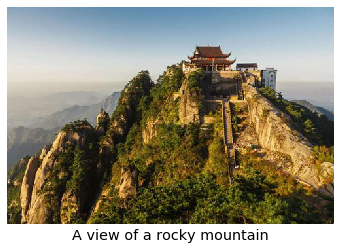

In [41]:
import requests
# If you are using a Jupyter notebook, uncomment the following line.
# %matplotlib inline
import matplotlib.pyplot as plt
import json
from PIL import Image
from io import BytesIO

# Add your Computer Vision subscription key and endpoint to your environment variables.
# if 'COMPUTER_VISION_SUBSCRIPTION_KEY' in os.environ:
#     subscription_key = os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']
# else:
#     print("\nSet the COMPUTER_VISION_SUBSCRIPTION_KEY environment variable.\n**Restart your shell or IDE for changes to take effect.**")
#     sys.exit()

endpoint = "https://westcentralus.api.cognitive.microsoft.com/"
# if 'COMPUTER_VISION_ENDPOINT' in os.environ:
#     endpoint = os.environ['COMPUTER_VISION_ENDPOINT']
subscription_key = "e9ba1308fb6742579d5fb5a223fb567b"
analyze_url = endpoint+ "vision/v2.1/analyze"

# Set image_url to the URL of an image that you want to analyze.
image_url = "https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=382560307,871806915&fm=26&gp=0.jpg"

headers = {'Ocp-Apim-Subscription-Key': subscription_key}
params = {'visualFeatures': 'Categories,Description,Color'}
data = {'url': image_url}
response = requests.post(analyze_url, headers=headers,
                         params=params, json=data)
response.raise_for_status()

# The 'analysis' object contains various fields that describe the image. The most
# relevant caption for the image is obtained from the 'description' property.
analysis = response.json()
print(json.dumps(response.json()))
image_caption = analysis["description"]["captions"][0]["text"].capitalize()

# Display the image and overlay it with the caption.
image = Image.open(BytesIO(requests.get(image_url).content))
plt.imshow(image)
plt.axis("off")
_ = plt.title(image_caption, size="x-large", y=-0.1)
plt.show()

# 分析本地图片

{'categories': [{'name': 'people_', 'score': 0.62109375}], 'color': {'dominantColorForeground': 'Grey', 'dominantColorBackground': 'Grey', 'dominantColors': ['Grey'], 'accentColor': '82494F', 'isBwImg': False, 'isBWImg': False}, 'description': {'tags': ['outdoor', 'person', 'sport', 'standing', 'woman', 'man', 'holding', 'frisbee', 'couple', 'people', 'posing', 'group', 'young', 'playing', 'elephant', 'park', 'girl', 'white', 'player', 'field', 'ball', 'game'], 'captions': [{'text': 'a group of people posing for the camera', 'confidence': 0.9338164633760968}]}, 'requestId': 'c3ba5e03-e808-4e76-aa47-c74de723aa4d', 'metadata': {'width': 533, 'height': 300, 'format': 'Jpeg'}}


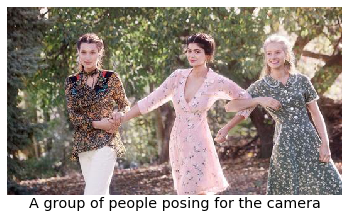

In [43]:
import os
import sys
import requests
# If you are using a Jupyter notebook, uncomment the following line.
# %matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# Add your Computer Vision subscription key and endpoint to your environment variables.
# if 'COMPUTER_VISION_SUBSCRIPTION_KEY' in os.environ:
#     subscription_key = os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']
# else:
#     print("\nSet the COMPUTER_VISION_SUBSCRIPTION_KEY environment variable.\n**Restart your shell or IDE for changes to take effect.**")
#     sys.exit()

# if 'COMPUTER_VISION_ENDPOINT' in os.environ:
#     endpoint = os.environ['COMPUTER_VISION_ENDPOINT']

# analyze_url = endpoint + "vision/v2.1/analyze"

# Set image_path to the local path of an image that you want to analyze.
image_path = "test.jpg"

# Read the image into a byte array
image_data = open(image_path, "rb").read()
headers = {'Ocp-Apim-Subscription-Key': subscription_key,
           'Content-Type': 'application/octet-stream'}
params = {'visualFeatures': 'Categories,Description,Color'}
response = requests.post(
    analyze_url, headers=headers, params=params, data=image_data)
response.raise_for_status()

# The 'analysis' object contains various fields that describe the image. The most
# relevant caption for the image is obtained from the 'description' property.
analysis = response.json()
print(analysis)
image_caption = analysis["description"]["captions"][0]["text"].capitalize()

# Display the image and overlay it with the caption.
image = Image.open(BytesIO(image_data))
plt.imshow(image)
plt.axis("off")
_ = plt.title(image_caption, size="x-large", y=-0.1)

# 缩略图

Thumbnail is 50-by-50


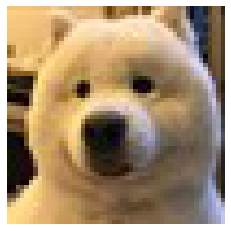

In [39]:
import os
import sys
import requests
# If you are using a Jupyter notebook, uncomment the following line.
# %matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# Add your Computer Vision subscription key and endpoint to your environment variables.
# if 'COMPUTER_VISION_SUBSCRIPTION_KEY' in os.environ:
#     subscription_key = os.environ['COMPUTER_VISION_SUBSCRIPTION_KEY']
# else:
#     print("\nSet the COMPUTER_VISION_SUBSCRIPTION_KEY environment variable.\n**Restart your shell or IDE for changes to take effect.**")
#     sys.exit()

# if 'COMPUTER_VISION_ENDPOINT' in os.environ:
#     endpoint = os.environ['COMPUTER_VISION_ENDPOINT']

thumbnail_url = endpoint + "vision/v2.1/generateThumbnail"

# Set image_url to the URL of an image that you want to analyze.
image_url = "https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=3181608523,3106512615&fm=26&gp=0.jpg"

headers = {'Ocp-Apim-Subscription-Key': subscription_key}
params = {'width': '50', 'height': '50', 'smartCropping': 'true'}
data = {'url': image_url}
response = requests.post(thumbnail_url, headers=headers,
                         params=params, json=data)
response.raise_for_status()

thumbnail = Image.open(BytesIO(response.content))

# Display the thumbnail.
plt.imshow(thumbnail)
plt.axis("off")

# Verify the thumbnail size.
print("Thumbnail is {0}-by-{1}".format(*thumbnail.size))